# The itertools Module
(the first part of this lecture is based on the material by [Dr. Gregory Watson](https://nyu-cds.github.io/python-itertools/))

In this class we will learn:
- more about code profiling

### More about code profile: the %prun magic command
(you have to install line-profiler before using prun)

Suppose we want to approximate $\pi$ using the formula
$$
\pi^2=6\,(1+\frac{1}{2^2}+\cdots+\frac{1}{n^2})
$$

In [16]:
def recip_square(i):
    return 1./i**2

def approx_pi(n=1000000):
    val = 0.
    for k in range(1,n+1):
        val += recip_square(k)
    return (6 * val)**.5

In [17]:
import time

t = time.process_time()
approx_pi()
elapsed_time = time.process_time() - t
print(elapsed_time)

0.5165900000000008


In [18]:
%timeit approx_pi()

515 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%prun approx_pi()

The first line of the profile contains the number of CPU seconds it took to run the code. You should see that the code was a little slower with %prun. This was because it ran inside the cProfile module.

Looking at the tottime column, we can see that approximately one third of the time is spent in __approx\_pi__ and the remainder is spent in __recip\_square__.

In [20]:
def approx_pi2(n=1000000):
    val = 0.
    for k in range(1,n+1):
        val += 1./k**2
    return (6 * val)**.5

In [21]:
%prun approx_pi2()

Sometimes the cause of the hotspot is a single line in a function, which may not be obvious from reading the source code or analyzing the output of cProfile.

The __line_profiler__ times the execution of each individual line inside a function.

The __line_profiler__ can be used by loading the line_profiler extension
````python
%load_ext line_profiler
````

The following code computes the list of prime numbers up to and including $n$ using the _Sieve of Eratosthenes_, which can be expressed in pseudocode as follows:

In [22]:
import numpy as np

def primes(n=1000): 
    A = [True] * (n+1)
    A[0] = False
    A[1] = False
    for i in range(2, int(n**0.5)):
        if A[i]:
            for j in range(i**2, n+1, i):
                A[j] = False

    return [x for x in range(2, n) if A[x]]

In [23]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [24]:
%lprun -f primes primes(100)

Are you able to speedup the code above?

----
Lets apply what we learned in the problem of solving the _heat equation_:
$$
\frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2}=0
$$
using central difference in a square $[0,1]\times[0,1]$ regular grid:
$$
\frac{\partial^2 f}{\partial x^2}\approx\frac{f_{i+1,j}-2f_{i,j}+f_{i-1,j}}{\Delta x^2}
$$

$$
\frac{\partial^2 f}{\partial y^2}\approx\frac{f_{i,j+1}-2f_{i,j}+f_{i,j-1}}{\Delta y^2}
$$
We will assume $f$ known in the boundary of the square domain.

To make our life easier, lets assume that $\Delta x = \Delta y$.

In [25]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [26]:
from itertools import product
import numpy as np

def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n,n))
    return(G)

def set_boundary_values(n):
    b = np.zeros((4,n))
    b[2]=1
    b[3]=1
    return(b)

def set_boundary_grid(G,b):
    '''set the boundary values: b[0]=botton, b[1]=top, b[2]=left, b[3]=right'''
    G[0,:]=b[0]
    G[-1,:]=b[1]
    G[:,0]=b[2]
    G[:,-1]=b[3]
    
def calc_error(G1,G2):
    error = 0
    n = G1.shape[0]
    for i in range(n):
        for j in range(n):
            error += (G1[i,j]-G2[i,j])**2
    return(error/n)

def copy_array(G1,G2):
    G2[:,:] = G1[:,:]
    
def itera(G):
    n = G.shape[0]
    for i in range(1,n-1):
        for j in range(1,n-1):
            G[i,j]=(G[i+1,j]+G[i-1,j]+G[i,j+1]+G[i,j-1])/4    

In [27]:
# Using numpy built-in functions to compute the error

def calc_error2(G1,G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return(error)

In [28]:
# Using iterators to traverse the grid

def itera2(G):
    n = G.shape[0]
    indices = product(range(1,n-1),repeat=2)
    for i in indices:
        G[i]=(G[i[0]+1,i[1]]+G[i[0]-1,i[1]]+G[i[0],i[1]+1]+G[i[0],i[1]-1])/4

In [29]:
# avoiding traverse the grid 

def itera3(G):
    n = G.shape[0]
    Gl = np.roll(G,1,axis=1)
    Gr = np.roll(G,n-1,axis=1)
    Gu = np.roll(G,1,axis=0)
    Gd = np.roll(G,n-1,axis=0)
    G[1:n-1,1:n-1]=(Gr[1:n-1,1:n-1]+Gl[1:n-1,1:n-1]+Gu[1:n-1,1:n-1]+Gd[1:n-1,1:n-1])/4.0

In [30]:
def solve_heat_equation(n):
    G = build_grid(n)
    b = set_boundary_values(n)
    set_boundary_grid(G,b)
    G_prev = build_grid(n)  # only need for computing the convergence
    copy_array(G,G_prev)
    error = 1e10
    while error > 1e-7:
        itera(G)
        error = calc_error(G,G_prev)
        copy_array(G,G_prev)    
        
    return(G)

In [31]:
def solve_heat_equation2(n):
    '''changing to calc_error2 function'''
    G = build_grid(n)
    b = set_boundary_values(n)
    set_boundary_grid(G,b)
    G_prev = build_grid(n)
    copy_array(G,G_prev)
    error = 1e10
    while error > 1e-7:
        itera(G)
        error = calc_error2(G,G_prev) 
        copy_array(G,G_prev)    
        
    return(G)

In [32]:
def solve_heat_equation3(n):
    '''changing to calc_error2 and itera2 functions'''
    G = build_grid(n)
    b = set_boundary_values(n)
    set_boundary_grid(G,b)
    G_prev = build_grid(n)
    copy_array(G,G_prev)
    error = 1e10
    while error > 1e-7:
        itera2(G)
        error = calc_error2(G,G_prev) 
        copy_array(G,G_prev)    
        
    return(G)

In [33]:
def solve_heat_equation4(n):
    '''changing to calc_error2 and itera3 functions'''
    G = build_grid(n)
    b = set_boundary_values(n)
    set_boundary_grid(G,b)
    G_prev = build_grid(n)
    copy_array(G,G_prev)
    error = 1e10
    while error > 1e-10:
        itera3(G)
        error = calc_error2(G,G_prev) 
        copy_array(G,G_prev)    
        
    return(G)

In [40]:
%prun G = solve_heat_equation4(100)

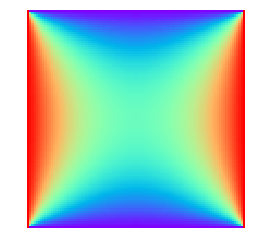

In [35]:
import matplotlib.pyplot as plt

img=plt.imshow(G)
img.set_cmap('rainbow')
plt.axis('off')
plt.show()

Understanding the numpy roll function

In [36]:
A = np.ones((5,5))
for i in range(5):
    A[:,i]=i
Al = np.roll(A,1,axis=1)
Ar = np.roll(A,4,axis=1)
print(A)
print(Al)
print(Ar)

[[ 0.  1.  2.  3.  4.]
 [ 0.  1.  2.  3.  4.]
 [ 0.  1.  2.  3.  4.]
 [ 0.  1.  2.  3.  4.]
 [ 0.  1.  2.  3.  4.]]
[[ 4.  0.  1.  2.  3.]
 [ 4.  0.  1.  2.  3.]
 [ 4.  0.  1.  2.  3.]
 [ 4.  0.  1.  2.  3.]
 [ 4.  0.  1.  2.  3.]]
[[ 1.  2.  3.  4.  0.]
 [ 1.  2.  3.  4.  0.]
 [ 1.  2.  3.  4.  0.]
 [ 1.  2.  3.  4.  0.]
 [ 1.  2.  3.  4.  0.]]


In [37]:
A = np.ones((5,5))
for i in range(5):
    A[i]=i
Ab = np.roll(A,1,axis=0)
At = np.roll(A,4,axis=0)
print(A)
print(Ab)
print(At)

[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.]]
[[ 4.  4.  4.  4.  4.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]]
[[ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.]
 [ 0.  0.  0.  0.  0.]]


itera, itera2 produce the same result, but itera3 generates a slightly different result

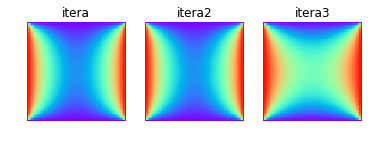

In [38]:
G_itera = solve_heat_equation2(70)
G_itera2 = solve_heat_equation3(70)
G_itera3 = solve_heat_equation4(70) 

plt.subplot(1,3,1)
plt.title('itera')
img=plt.imshow(G_itera)
img.set_cmap('rainbow')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('itera2')
img=plt.imshow(G_itera2)
img.set_cmap('rainbow')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('itera3')
img=plt.imshow(G_itera3)
img.set_cmap('rainbow')
plt.axis('off')

plt.show()


What is the source of the difference?